# H(div)-conforming Navier-Stokes mon Surfaces

C. Lehrenfeld, P. Lederer, JS '20

Using element-wise Piola-transform to map 2D H(div) onto manifolds $S$.

$$
\Phi_T : T \subset {\mathbb R}^2 \rightarrow {\mathbb R}^3
$$

Jacobi matrix:

$$
F_T = \Phi_T^\prime \in {\mathbb R}^{3 \times 2}
$$

Piola transform:

$$
u(\Phi_T(x)) = \det(F^T F)^{-1/2} F_T \hat u(x)
$$

Viscosity term:

$$
a(u, v) = \int_S (\nabla_T u)^{sym} : (\nabla_T v)^{sym}
$$

with the covariant gradient 

$$
\nabla_T u = P_T \, \nabla_{surf} u
$$

using projection onto tangential space, and surface gradient $\nabla_{surf}$

In [ ]:
from netgen.occ import *
from ngsolve import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
from netgen.meshing import MeshingStep

In [ ]:
circ = Circle( (1,0,0), -Y, 0.2)
shell = Revolve(circ, Axis((0,0,0), Z), 180)

shell.edges.name = "dummyedge"
shell.edges[X>0][Y<0.01].name = "inflow"
shell.edges[X<0][Y<0.01].name = "outflow"

shell -= Sphere ((1.2*cos(0.3),1.2*sin(0.3),0), 0.1)

for e in shell.edges:
    if e.name==None: e.name="cyl"

DrawGeo (shell)

geo = OCCGeometry(shell)
ngmesh = geo.GenerateMesh(perfstepsend=MeshingStep.MESHSURFACE,maxh=0.1)
mesh = Mesh(ngmesh).Curve(3)
Draw (mesh);

In [ ]:
mesh.GetBBoundaries()

In [ ]:
order = 3
maxh = 0.1
dt = 0.002

alpha = 10
nu = 0.001

gamma = 1 - sqrt(0.5)
delta = 1 - 1/(2*gamma)

VDivSurf = HDivSurface(mesh, order = order)
VHat = HCurl(mesh, order = order, orderface = 0)
Q = SurfaceL2(mesh, order = order-1)

V = VDivSurf*VHat*Q

u, uhat, p = V.TrialFunction()
v, vhat, q = V.TestFunction()

normal = specialcf.normal(3)
tangential = specialcf.tangential(3)
n = Cross(normal,tangential)

proj = Id(3) - OuterProduct(normal, normal)

def tang(vec):
    return vec-(vec*n)*n

h = specialcf.mesh_size

gradu = proj * grad(u) * proj
gradv = proj * grad(v) * proj

epsu = 0.5*(gradu + gradu.trans)
epsv = 0.5*(gradv + gradv.trans)

vhat = vhat.Trace()
uhat = uhat.Trace()

m = BilinearForm(u.Trace()*v.Trace()*ds).Assemble()

dS = ds(element_boundary=True) 

a = BilinearForm(V)
a += 2*nu*InnerProduct(epsu, epsv)*ds
a += 2*nu*InnerProduct(epsu*n,  tang(vhat-v.Trace()) )*dS
a += 2*nu*InnerProduct(epsv*n,  tang(uhat-u.Trace()) )*dS
a += nu*alpha*order*order/h*InnerProduct ( tang(vhat-v.Trace()),  tang(uhat-u.Trace()) )*dS
a += div(u.Trace())*q.Trace()*ds
a += div(v.Trace()) *p.Trace()*ds
a += 1e-8*p.Trace() *q.Trace()*ds
a.Assemble()

conv = BilinearForm(V, nonassemble=True)
conv += (-InnerProduct(gradv*u.Trace(), u.Trace()) * ds).Compile()
u_Other = (u.Trace()*n)*n + tang(uhat)
conv += (IfPos(u.Trace() * n, u.Trace()*n*u.Trace()*v.Trace(), u.Trace()*n*u_Other*v.Trace()) * ds(element_boundary = True)).Compile()

f = LinearForm(V)
f.Assemble()

inflowdofs = V.GetDofs(mesh.BBoundaries("inflow"))
cyldofs = V.GetDofs(mesh.BBoundaries("cyl"))

freedofs = ~(inflowdofs | cyldofs)
gfu = GridFunction(V)

gfu.components[0].Set((0,1,0), definedon=mesh.Boundaries(".*"))
Projector(inflowdofs, True).Project(gfu.vec)

invstokes = a.mat.Inverse(freedofs, inverse="sparsecholesky")
gfu.vec.data -= invstokes@a.mat * gfu.vec

Draw (gfu.components[0]);

In [ ]:
velocity = gfu.components[0]
scenevel = Draw(velocity, mesh, name = "velocity")
scenepressure = Draw(- gfu.components[2], mesh, name = "pressure")


invstokes = a.mat.Inverse(freedofs, inverse ="sparsecholesky")
res = gfu.vec.CreateVector()
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += invstokes * res

mstar = m.mat.CreateMatrix()
mstar.AsVector().data = m.mat.AsVector() + gamma * dt * a.mat.AsVector()

inv = mstar.Inverse(freedofs, inverse="sparsecholesky")

tend = 20
t = 0
k=0
convvec, convvec1, convvec2 = gfu.vec.CreateVectors(3)
diffvec1, diffvec2 = gfu.vec.CreateVectors(2)
u1 = gfu.vec.CreateVector()


with TaskManager():
    while t < tend:
        # IMEXRK2
        convvec1.data = conv.mat * gfu.vec 
        diffvec1.data = a.mat * gfu.vec
        res.data = convvec1 + diffvec1
        u1.data = gfu.vec.data - gamma * dt * inv * res
          
        convvec2.data = conv.mat * u1
        diffvec2.data = a.mat * u1

        res.data = delta*convvec1 + (1-delta)*convvec2 + \
             gamma*diffvec1 + (1-gamma)*diffvec2
        gfu.vec.data -= dt * inv * res
          
        t = t + dt
        k = k + 1

        scenevel.Redraw()
        scenepressure.Redraw()

Kelvin-Helmholty on the sphere:
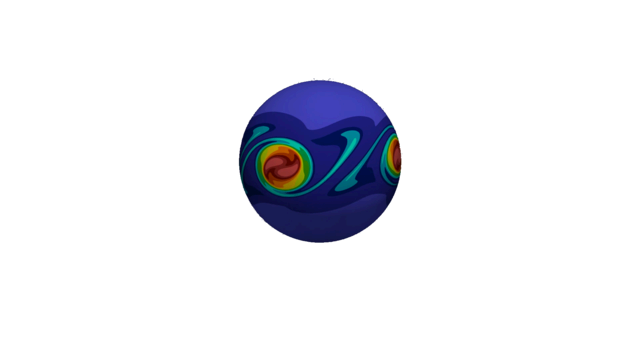

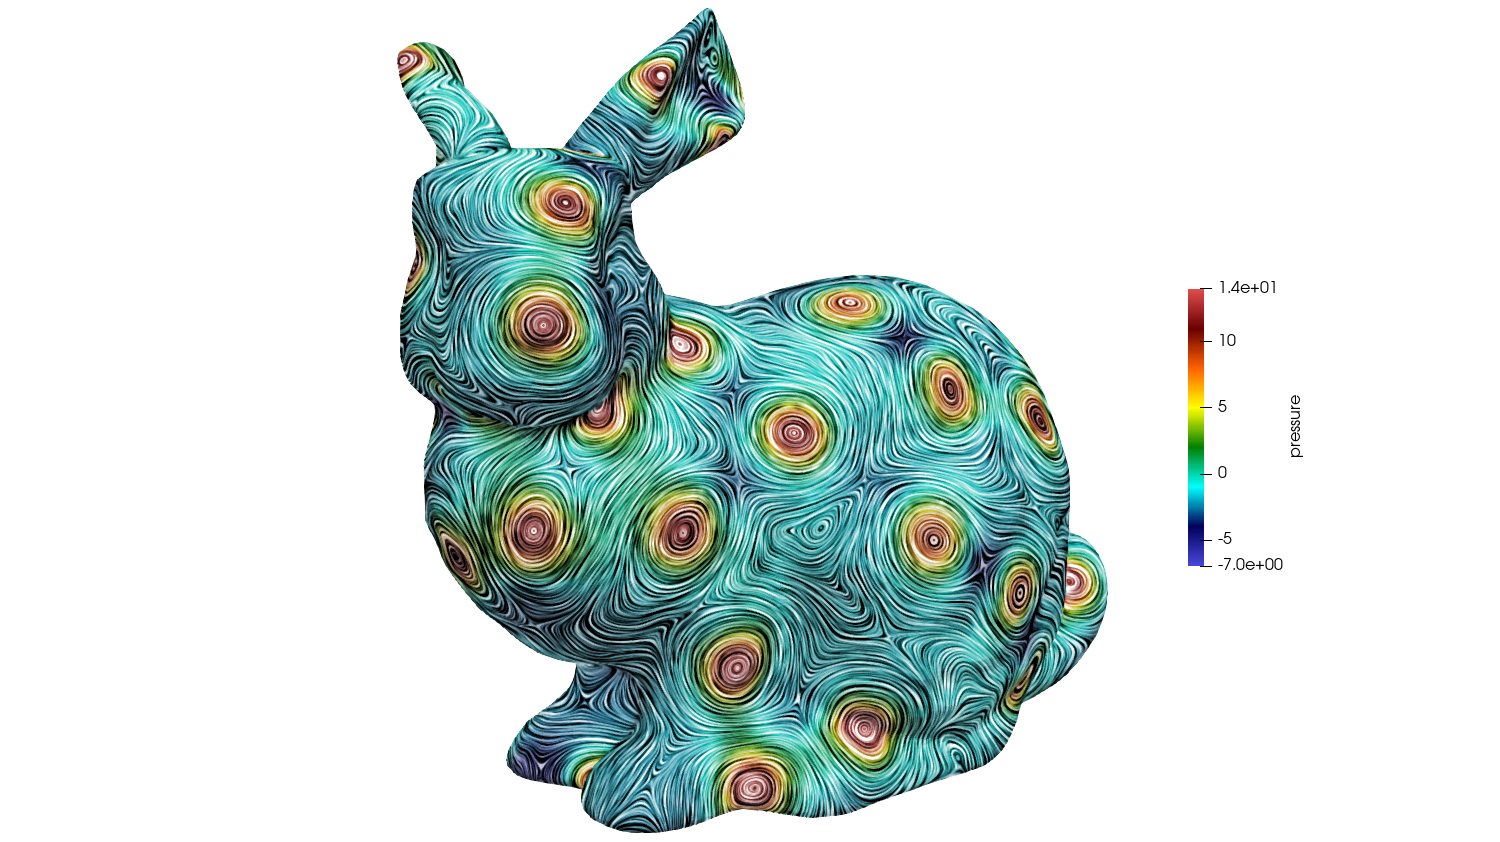